# Relatedness and Population structure

## 5.1 Genetic Relatedness

### 5.1.2 Estimating relatedness

##### Example 5.1

In [1]:
offspring.geno <- function(n.families, n.snps, fs=rep(0.50, n.snps), n.shared.parents=2) {
    # INPUT:
    #   n.families, number of families where each family produces two offspring (>0)
    #   n.snps, number of independent SNPs used in simulation (>0)
    #   fs, vector of allele 1 freqs for SNPs, length == n.snps, values >0 & <1
    #   n.shared.parents, 0, 1, 2 shared parents for the two offspring in each family
    # OUTPUT:
    #   X, genotypes of (2*n.families) offspring, (2*n.families) x n.snps matrix with 0, 1, 2 entries
    
    stopifnot(n.families > 0)
    stopifnot(n.snps > 0)
    stopifnot(all(fs>0 & fs<1) & length(fs)==n.snps)
    stopifnot(n.shared.parents %in% 0:2)
    
    if(n.shared.parents==2) parents = list(c(1, 2), c(1, 2))
    if(n.shared.parents==1) parents = list(c(1, 2), c(3, 2))
    if(n.shared.parents==0) parents = list(c(1, 2), c(3, 4))
    n.parents = 4 - n.shared.parents
    
    X = matrix(0, nrow=2*n.families, ncol=n.snps)
    for(ii in 1:n.families) {
        # each family means a pair of offsprings that share 'n.shared.parents'
        x.parents = t(replicate(2*n.parents, rbinom(n.snps, size=1, prob=fs)))
        for(offs in 1:2) { # for two offspring within "family"
            # phase is the indicator that whether offs inherit each parents first allele or not
            phase = t(replicate(2, rbinom(n.snps, size=1, prob=0.50))) # phase has one row for each parent
            for(i.parent in 1:2) {
                for(ph in 0:1) {
                    loci = (phase[i.parent,] == ph) # which loci from i.parent have phase ph?
                    # add to the current offs' genotype i.parent's allele from the correct phase
                    X[2*(ii-1) + offs, loci] = X[2*(ii-1) + offs, loci] + x.parents[2*parents[[offs]][i.parent] - ph, loci]
                }
            }
        }
    }
    return (X)
}

In [2]:
p = 10000 # SNPs
fs = runif(p, 0.2, 0.5) # MAF at each SNP is Uniform(0.2, 0.5)

X = rbind(
    offspring.geno(n.families=5, n.snps=p, fs=fs, n.shared.parents=0),
    offspring.geno(n.families=5, n.snps=p, fs=fs, n.shared.parents=1),
    offspring.geno(n.families=5, n.snps=p, fs=fs, n.shared.parents=2)
)

X = X[,apply(X, 2, var)>0] # remove possible monomorphic variants

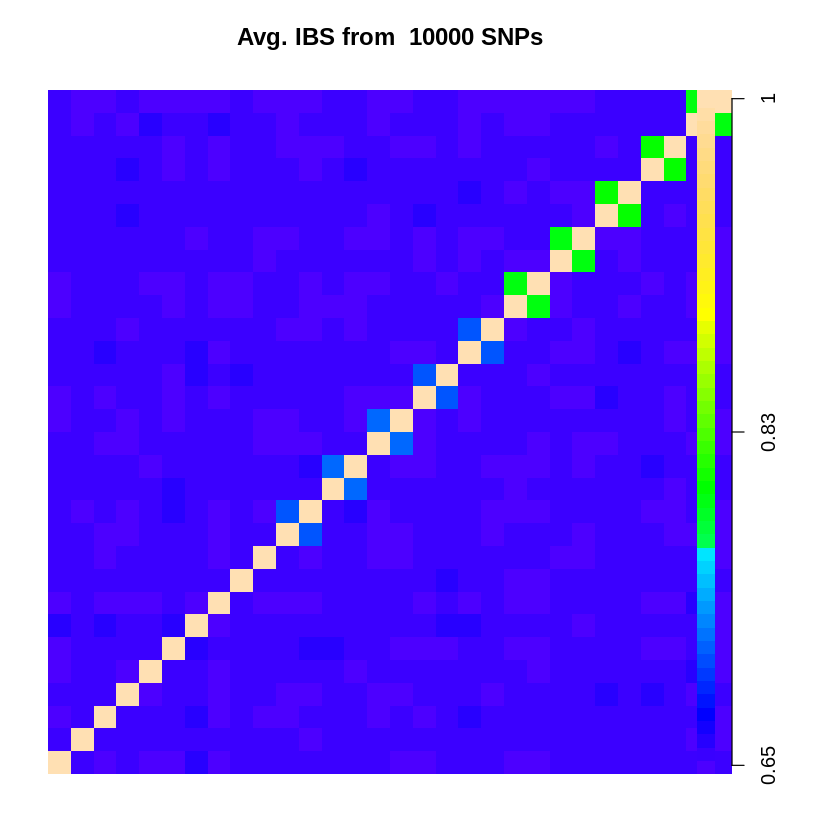

In [9]:
n.cols = 50 # number of colors
IBS.2 = ((X==2) %*% t(X==2) + (X==1) %*% t(X==1) + (X==0) %*% t(X==0)) / p
IBS.1 = ((X==1) %*% t(X==0|X==2) + (X==0|X==2) %*% t(X==1)) / p
IBS = IBS.2 + 0.50 * IBS.1 # proportion of genome IBS
layout(matrix(c(1, 2), nrow=1), width=c(9, 1)) # plotting area divided into 9/10 and 1/10 wide regions
par(mar=c(2, 2, 3, 1)) # plot IBS matrix using image
image(IBS, col=topo.colors(n.cols), breaks=seq(min(IBS), max(IBS), length=n.cols+1),
     asp=1, xaxt="n", yaxt="n", bty="n",
     main=paste("Avg. IBS from ", ncol(X), "SNPs"))
par(mar=c(2, 1, 3, 1)) # plot scale for colors
plot.window(xlim=c(0, 1), ylim=c(0, n.cols))
points(x=rep(1, n.cols+1), y=(0:n.cols), col=topo.colors(n.cols+1), pch=15, cex=2)
axis(4, at=c(0, n.cols/2, n.cols),
    labels=c(round(min(IBS), 2), round((min(IBS) + max(IBS))/2, 2), round(max(IBS), 2)))

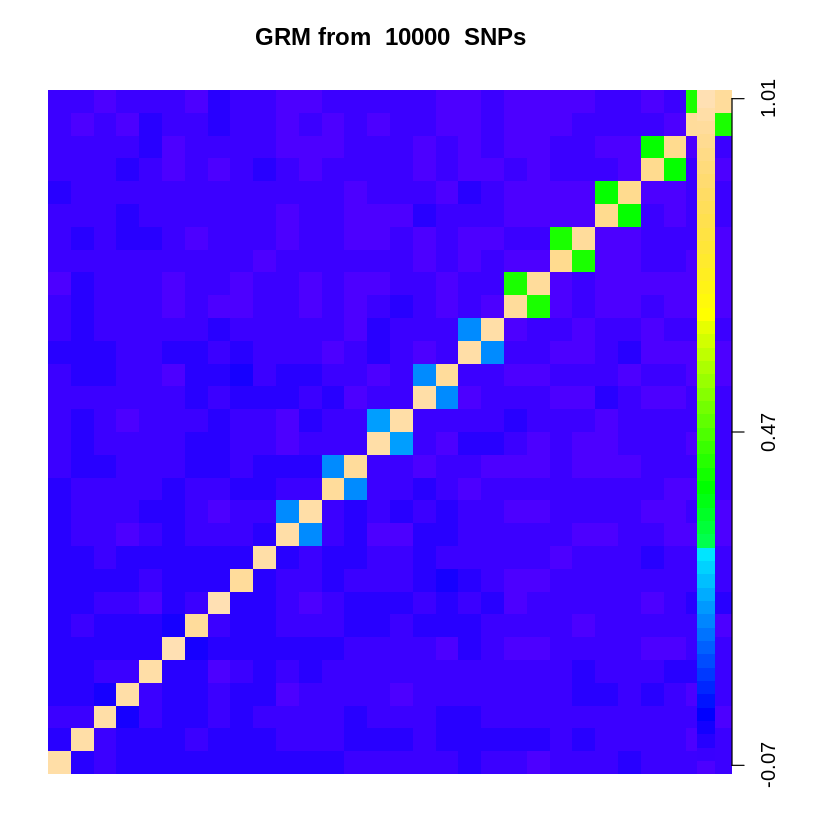

In [36]:
X.scaled = scale(X) # standardize each SNP at columns of X
GRM = (X.scaled %*% t(X.scaled)) / p # correlation matrix of individuals based on standardized SNPs

layout(matrix(c(1, 2), nrow=1), width=c(9, 1))
par(mar=c(2, 2, 3, 1)) # margins for matrix
image(GRM, col=topo.colors(n.cols), breaks=seq(min(GRM), max(GRM), length=n.cols+1),
     asp=1, xaxt="n", yaxt="n", bty="n",
     main=paste("GRM from ", ncol(X), " SNPs"))
par(mar=c(2, 1, 3, 1)) # margins for scale
plot.window(xlim=c(0, 1), ylim=c(0, n.cols))
points(x=rep(1, n.cols+1), y=(0:n.cols), col=topo.colors(n.cols+1), pch=15, cex=2)
axis(4, at=c(0, n.cols/2, n.cols),
    labels=c(round(min(GRM), 2), round((min(GRM)+max(GRM))/2, 2), round(max(GRM), 2)) )

In [41]:
full.sibs = which(GRM>0.40 & GRM<0.60, arr.ind=T) # each pair twice since R is symmetric
full.sibs = full.sibs[full.sibs[,1] < full.sibs[,2]] # pick only pairs where first index is less than second index
rbind(full=as.vector(t(full.sibs)))

full,21,23,25,27,29,22,24,26,28,30


In [43]:
half.sibs = which(GRM>0.40 & GRM<0.60, arr.ind=T)
half.sibs = half.sibs[half.sibs[,1] < half.sibs[,2]]
rbind(full=as.vector(t(half.sibs)))

full,21,23,25,27,29,22,24,26,28,30


##### KING

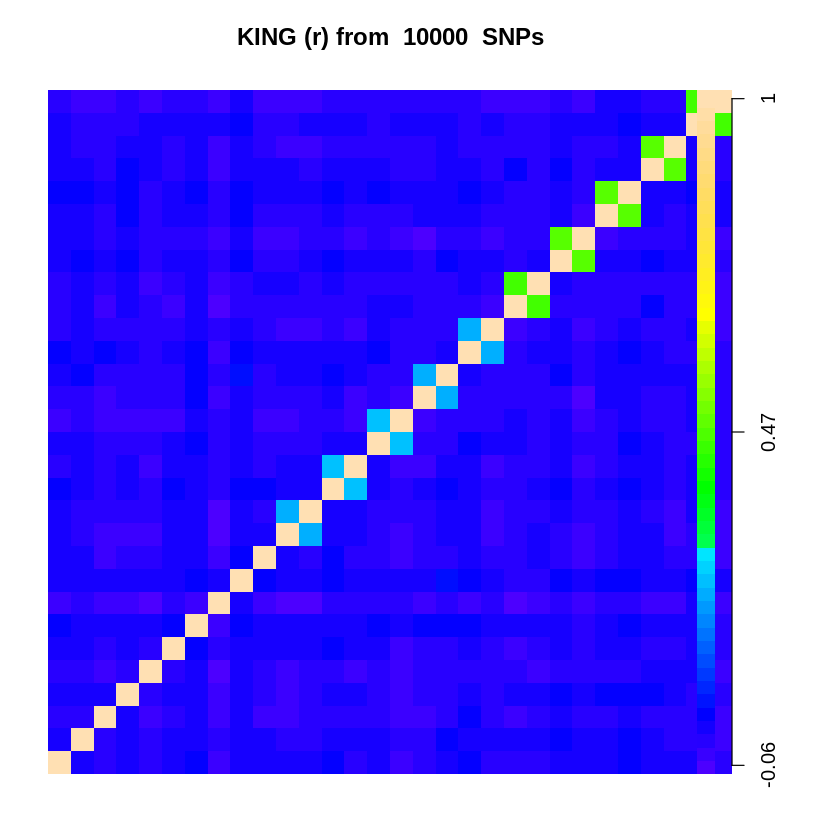

In [46]:
denominator = matrix(rep(rowSums(X==1), nrow(X)), nrow=nrow(X), byrow=T) +
              matrix(rep(rowSums(X==1), nrow(X)), nrow=nrow(X), byrow=F)
king.r = 2*((X==1) %*% t(X==1) - 2*((X==0) %*% t(X==2) + (X==2) %*% t(X==0))) /denominator

layout(matrix(c(1, 2), nrow=1), width=c(9, 1))
par(mar=c(2, 2, 3, 1)) # margins for matrix
image(king.r, col=topo.colors(n.cols), breaks=seq(min(king.r), max(king.r), length=n.cols+1),
     asp=1, xaxt="n", yaxt="n", bty="n",
     main=paste("KING (r) from ", ncol(X), " SNPs"))
par(mar=c(2, 1, 3, 1)) # margins for scale
plot.window(xlim=c(0, 1), ylim=c(0, n.cols))
points(x=rep(1, n.cols+1), y=(0:n.cols), col=topo.colors(n.cols+1), pch=15, cex=2)
axis(4, at=c(0, n.cols/2, n.cols),
    labels=c(round(min(king.r), 2), round((min(king.r)+max(king.r))/2, 2), round(max(king.r), 2)) )

### 5.1.3 Use of IBD estimates in quality control